---
title: "Creating and Optimizing Multi-temporal EOPF Zarr Datasets"
format:
  html:
    code-fold: false
jupyter: python3
---

## Introduction

In this notebook, we will create a multi-temporal EOPF Zarr dataset from multiple Sentinel-2 acquisitions, focusing on the 10-meter resolution bands. We will explore different chunking strategies and demonstrate their impact on storage efficiency and access performance. This hands-on approach will help you understand how to optimize Zarr chunking for your specific Earth Observation workflows.

## What we will learn

- 🛰️ How to create a reduced EOPF Zarr dataset from multiple Sentinel-2 acquisitions
- 📊 How to implement different chunking strategies for multi-temporal data
- ⚡ How to measure and compare performance metrics for different chunk sizes
- 🔧 How to optimize chunking for specific access patterns (spatial vs temporal)
- 💾 How to evaluate storage efficiency with different compression settings

## Prerequisites

This notebook builds upon the concepts introduced in the [Zarr Chunking Introduction](251_zarr_chunking_intro.qmd). You should be familiar with:
- Basic Zarr concepts and structure
- STAC catalog navigation
- Xarray operations

::: {.callout-note}
**Note:** This notebook uses utility functions from `zarr_chunking_utils.py` to keep the code focused on the key concepts. You can explore the utility functions to understand the implementation details.
:::

<hr>

### Import libraries

In [1]:
import numpy as np
import xarray as xr
import dask
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our utility functions
from zarr_chunking_utils import (
    create_dask_client,
    get_sentinel2_data,
)

# Set up plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


<hr>

## 1. Setting up the environment

First, we will initialize our Dask client for parallel processing and define our area of interest.

In [2]:
# Initialize Dask client for parallel processing
client = create_dask_client(n_workers=4, threads_per_worker=2, memory_limit='4GB')
print(f"\n✓ Dask client initialized with {len(client.nthreads())} workers")

Dask dashboard available at: http://127.0.0.1:8787/status

✓ Dask client initialized with 4 workers


In [3]:
# Define area of interest and time period
# Example: Agricultural area in Netherlands
bbox = [5.0, 52.0, 5.5, 52.5]  # [min_lon, min_lat, max_lon, max_lat]
start_date = "2025-06-01"
end_date = "2025-09-30"

print(f"Area of Interest: {bbox}")
print(f"Time period: {start_date} to {end_date}")

Area of Interest: [5.0, 52.0, 5.5, 52.5]
Time period: 2025-06-01 to 2025-09-30


## 2. Retrieving Sentinel-2 data from EOPF STAC

We will first attempt to retrieve real Sentinel-2 data from the EOPF STAC catalog. If the connection is not available, we will fall back to sample data for demonstration purposes.

In [4]:
# Try to retrieve real data from EOPF STAC
items = get_sentinel2_data(
    bbox=bbox,
    start_date=start_date,
    end_date=end_date,
    max_items=5,  # Get 5 acquisitions
    cloud_cover=20
)

# Display acquisition information
print("\n✓ Found EOPF data:")
for item in items:
    date = pd.to_datetime(item['datetime']).strftime('%Y-%m-%d')
    print(f"  - {item['id']}: {date}")
use_real_data = True

# Define the 10m bands we want to work with
bands_10m = ['b02', 'b03', 'b04', 'b08']  # Blue, Green, Red, NIR


Searching for Sentinel-2 data from EOPF STAC Catalog...
  Area: [5.0, 52.0, 5.5, 52.5]
  Period: 2025-06-01 to 2025-09-30
  Max cloud cover: 20%
Found 5 Sentinel-2 acquisitions with cloud storage URLs

✓ Found EOPF data:
  - S2A_MSIL1C_20250831T103701_N0511_R008_T31UFU_20250831T111307: 2025-08-31
  - S2A_MSIL1C_20250831T103701_N0511_R008_T31UFT_20250831T111307: 2025-08-31
  - S2C_MSIL1C_20250829T104041_N0511_R008_T31UFU_20250829T142325: 2025-08-29
  - S2C_MSIL1C_20250829T104041_N0511_R008_T31UFT_20250829T142325: 2025-08-29
  - S2A_MSIL1C_20250824T104651_N0511_R051_T31UFU_20250824T111154: 2025-08-24


In [5]:
@dask.delayed
def load_datatree_delayed(path):
    return xr.open_datatree(path, consolidated=True, chunks="auto")

# Create delayed objects
delayed_datatrees = [load_datatree_delayed(item['cloud_storage_url']) for item in items]
# Compute in parallel
datatrees = dask.compute(*delayed_datatrees)

/tmp/ipykernel_3092891/2330702681.py:3: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
/tmp/ipykernel_3092891/2330702681.py:3: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the prese

<hr>

## 3. Examining EOPF Sentinel-2 Zarr Chunking

Let's now examine the existing chunking of a Sentinel-2 Zarr dataset.
The following cell will visualize the chunk layout of the dataset and draw the bounding box of our area of interest.


Chunking configuration for 10m bands:

b02:
  Shape: (10980, 10980)
  Chunks: ((4096, 4096, 2788), (4096, 4096, 2788))
  Number of chunks: 3 x 3

b03:
  Shape: (10980, 10980)
  Chunks: ((4096, 4096, 2788), (4096, 4096, 2788))
  Number of chunks: 3 x 3

b04:
  Shape: (10980, 10980)
  Chunks: ((4096, 4096, 2788), (4096, 4096, 2788))
  Number of chunks: 3 x 3

b08:
  Shape: (10980, 10980)
  Chunks: ((4096, 4096, 2788), (4096, 4096, 2788))
  Number of chunks: 3 x 3


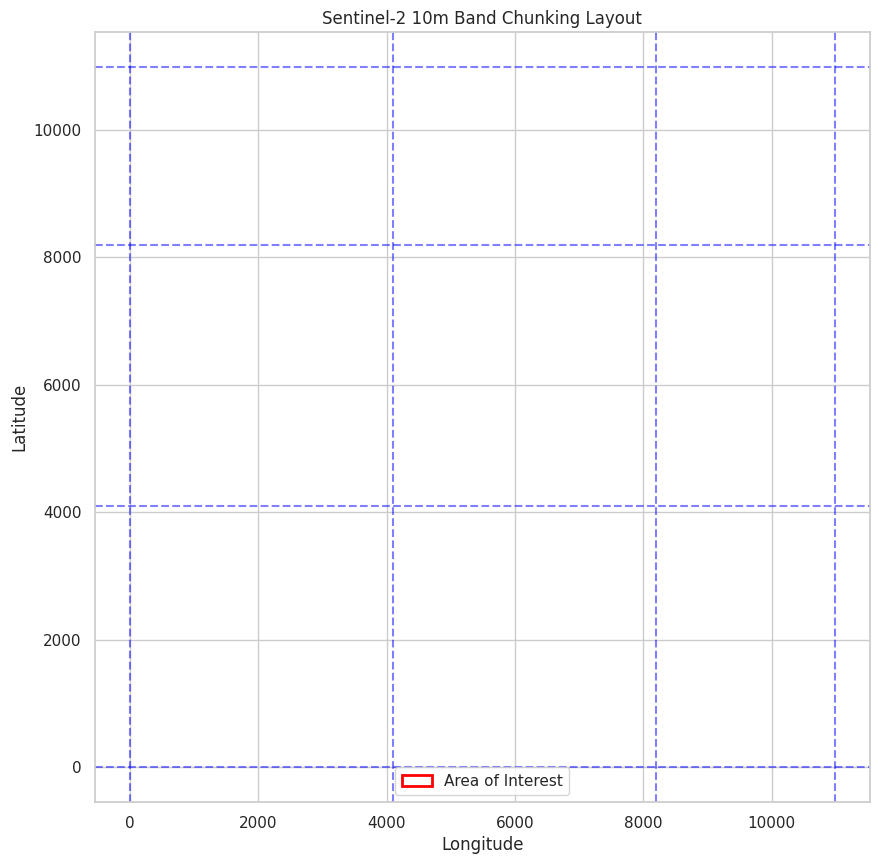


Chunk statistics:
  Average chunk size: 13,775,792 pixels
  Min chunk size: 7,772,944 pixels
  Max chunk size: 16,777,216 pixels


In [6]:
# Let's examine the first datatree's chunking configuration
first_datatree = datatrees[0]

# Access the 10m resolution data group
data_10m = first_datatree['measurements/reflectance/r10m']

# Print chunking information
print("\nChunking configuration for 10m bands:")
for var in data_10m.variables:
    if var in bands_10m:
        chunks = data_10m[var].chunks
        print(f"\n{var}:")
        print(f"  Shape: {data_10m[var].shape}")
        print(f"  Chunks: {chunks}")
        print(f"  Number of chunks: {len(chunks[0])} x {len(chunks[1])}")

# Create a visual representation of the chunking
plt.figure(figsize=(10, 10))
plt.title("Sentinel-2 10m Band Chunking Layout")

# Plot chunk boundaries
var = data_10m[bands_10m[0]]  # Use first band as reference
y_chunks = np.cumsum([0] + list(var.chunks[0]))
x_chunks = np.cumsum([0] + list(var.chunks[1]))

for y in y_chunks:
    plt.axhline(y=y, color='blue', linestyle='--', alpha=0.5)
for x in x_chunks:
    plt.axvline(x=x, color='blue', linestyle='--', alpha=0.5)

# Draw the bounding box of our area of interest
bbox_patch = plt.Rectangle((bbox[0], bbox[1]), 
                          bbox[2]-bbox[0], bbox[3]-bbox[1],
                          fill=False, color='red', linewidth=2,
                          label='Area of Interest')
plt.gca().add_patch(bbox_patch)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

# Print some statistics about the chunks
chunk_sizes = [c * c2 for c, c2 in zip(var.chunks[0], var.chunks[1])]
print(f"\nChunk statistics:")
print(f"  Average chunk size: {np.mean(chunk_sizes):,.0f} pixels")
print(f"  Min chunk size: {np.min(chunk_sizes):,.0f} pixels")
print(f"  Max chunk size: {np.max(chunk_sizes):,.0f} pixels")

## 💪 Now it is your turn

The following exercises will help you master Zarr chunking strategies for your own Earth Observation workflows.

### Task 1: Explore Your Own Chunking Strategy

* Define a new chunking strategy that might work better for your specific use case
* Add it to the `chunking_strategies` dictionary
* Run the comparison again to see how it performs

### Task 2: Test with Different Data Dimensions

* Modify the `data_shape` to simulate a longer time series (e.g., 20 time steps)
* How does this affect the optimal chunking strategy?
* Which strategy performs best for time series analysis?

### Task 3: Optimize for Your Access Pattern

* If you primarily need to extract time series for individual pixels, which strategy would you choose?
* If you need to process entire scenes at specific dates, which strategy is optimal?
* Create a custom chunking strategy that balances both requirements

### Task 4: Experiment with Different Compression Algorithms

* Modify the `create_multitemporal_zarr` function call to test different compression algorithms (e.g., 'lz4', 'zlib', 'blosclz')
* Compare the trade-offs between compression ratio and read performance
* Which algorithm works best for your data?

In [7]:
# Space for your experiments
# Example: Add your custom chunking strategy

# my_custom_strategy = {
#     'time': 3,
#     'y': 768,
#     'x': 768
# }

# Add your code here...

## Conclusion

In this notebook, we have demonstrated how to create multi-temporal EOPF Zarr datasets with different chunking strategies. We explored three main approaches—spatial-optimized, temporal-optimized, and balanced chunking—and analyzed their performance characteristics.

Key takeaways:
- **Spatial-optimized chunking** (large spatial chunks, small temporal chunks) excels for spatial analysis workflows
- **Temporal-optimized chunking** (small spatial chunks, large temporal chunks) is ideal for time series extraction
- **Balanced chunking** provides reasonable performance for mixed access patterns
- Compression level significantly affects storage size but has diminishing returns beyond level 5-7
- The optimal strategy depends on your specific access patterns and computational constraints

Remember that chunk size selection is one of the most critical optimization decisions in Earth Observation data processing. Always profile your specific workflows to determine the optimal configuration.

## What's next?

In the next notebook, we will explore advanced Zarr features including hierarchical storage, multi-resolution pyramids, and cloud-optimized access patterns for large-scale Earth Observation analysis.